## **OPIM 5509: Introduction to Deep Learning**
### * Homework #2: Weather Forecast CNN
### * Author: Qi Zhou

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Packages Setup

In [0]:
# import general necessary packages
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, cv2
# import the necessary packages -- cnn_regression
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from numpy.random import seed
from tensorflow import set_random_seed
from numpy import savez_compressed
from keras.callbacks import EarlyStopping


# **Part 1: ConvNets Prediction for Wind Speed**

### 1.1 Prepare the Data

#### 1) Image Data of Maps

In [0]:
#1: separate images into train, val, and test
path = "/content/drive/My Drive/Deep Learning/Week 2/Weather Prediction/"
train_dir = path + "Train/"
val_dir = path + "Validation/"
test_dir = path + "Test/"
result = path + "Models/"

In [0]:
#2: convert images into numpy array 
# load image train data
x_train_images = []
# make sure to read it in order
for image_path in sorted(os.listdir(train_dir)):
  img_path = train_dir + image_path
  image = cv2.imread(img_path)
  x_train_images.append(image)
x_train = np.array(x_train_images)

In [0]:
# load image validation data
x_val_images = []
# make sure to read it in order
for image_path in sorted(os.listdir(val_dir)):
  img_path = val_dir + image_path
  image = cv2.imread(img_path)
  x_val_images.append(image)
x_val = np.array(x_val_images)

In [0]:
# load image test data
x_test_images = []
# make sure to read it in order
for image_path in sorted(os.listdir(test_dir)):
  img_path = test_dir + image_path
  image = cv2.imread(img_path)
  x_test_images.append(image)
x_test = np.array(x_test_images)

In [0]:
# save loaded and converted image data 
savez_compressed(path+'train_data.npz', x_train)
savez_compressed(path+'val_data.npz', x_val)
savez_compressed(path+'test_data.npz', x_test)

In [0]:
# load image numpy array from npz file
from numpy import load
# load dict of arrays
train_data = load(path+'train_data.npz')
x_train = train_data['arr_0']
val_data = load(path+'val_data.npz')
x_val = val_data['arr_0']
test_data = load(path+'test_data.npz')
x_test = test_data['arr_0']

#### 2) Structured Data of Weather

In [13]:
# import weather data
target_data = pd.read_csv("/content/drive/My Drive/Deep Learning/Week 2/Weather Prediction/model_ready.csv")
target_data.head()

,valid,tmpf,drct,sknt
0,2016-09-01 00:00:00,75.02,222.500000,5.125000
1,2016-09-01 01:00:00,73.94,202.857143,4.857143
2,2016-09-01 02:00:00,73.94,218.181818,4.272727
3,2016-09-01 03:00:00,73.94,204.444444,4.555556
4,2016-09-01 04:00:00,73.04,145.000000,2.700000


In [14]:
# convert to a timedate
target_data['valid'] =  pd.to_datetime(target_data['valid'])
# set timedate to index
target_data = target_data.set_index('valid')
target_data.isna().sum()

tmpf    21
drct     7
sknt     3
dtype: int64

In [15]:
target_data[target_data.drct == 0]

,tmpf,drct,sknt
valid,,,
2016-09-01 15:00:00,69.98,0.0,0.0
2016-09-04 00:00:00,62.96,0.0,0.0
2016-09-10 06:00:00,73.04,0.0,0.0
2016-09-12 09:00:00,51.08,0.0,0.0
2016-09-13 06:00:00,55.04,0.0,0.0
...,...,...,...
2017-08-24 10:00:00,57.90,0.0,0.0
2017-08-26 10:00:00,51.10,0.0,0.0
2017-08-28 04:00:00,55.00,0.0,0.0


In [16]:
target_data = target_data.fillna(0)
target_data.head()

,tmpf,drct,sknt
valid,,,
2016-09-01 00:00:00,75.02,222.500000,5.125000
2016-09-01 01:00:00,73.94,202.857143,4.857143
2016-09-01 02:00:00,73.94,218.181818,4.272727
2016-09-01 03:00:00,73.94,204.444444,4.555556
2016-09-01 04:00:00,73.04,145.000000,2.700000


In [0]:
# fill the 0 with the past 5 hous mean
# tmpf column
for i in range(0,8719):
  if target_data.iloc[i][0] == 0:
    target_data['tmpf'].iloc[i] = total = target_data['tmpf'].iloc[i-5:i].mean()
# drct column
  if target_data.iloc[i][1] == 0:
    target_data['drct'].iloc[i] = total = target_data['drct'].iloc[i-5:i].mean()

In [18]:
target_data[target_data.drct == 0] # no 0s anymore

,tmpf,drct,sknt
valid,,,


In [0]:
#3: set train and test dataset
a = pd.Timestamp('2017/06/01 00:00:00')
b = pd.Timestamp('2017/08/01 00:00:00')
sample = target_data[target_data.index < b]
train = target_data[target_data.index < a]
val = sample[sample.index >= a]
test = target_data[target_data.index >= b]
# separate the data into train, validation and test
# tmpf model
# y_train_1 = train['tmpf']
# y_val_1 = val['tmpf']
# y_test_1 = test['tmpf']
# drct model
# y_train_2 = train['drct']
# y_val_2 = val['drct']
# y_test_2 = test['drct']
# sknt model
y_train_3 = train['sknt']
y_val_3 = val['sknt']
y_test_3 = test['sknt']

In [20]:
#4:  check the shape
print("Image train dataset shape: ", x_train.shape, "Weather train dataset shape: ", train.shape)
print("Image validation dataset shape: ", x_val.shape, "Weather validation dataset shape: ", val.shape)
print("Image test dataset shape: ", x_test.shape, "Weather test dataset shape: ", test.shape)

Image train dataset shape:  (6511, 125, 145, 3) Weather train dataset shape:  (6511, 3)
Image validation dataset shape:  (1464, 125, 145, 3) Weather validation dataset shape:  (1464, 3)
Image test dataset shape:  (744, 125, 145, 3) Weather test dataset shape:  (744, 3)


### 1.2 ConvNet Regression Model

#### 1) Model Architecture

In [0]:
#5: build the CNN model
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', input_shape=(125,145,3))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

# Add one more layer
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='linear'))

In [0]:
#opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(optimizer='rmsprop',loss="mse", metrics=['mae'])

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', 
                   # LOOK HOW QUICK IT STOPS IF YOU DON'T USE
                   # PATIENCE - SUBJECT TO NOISE!!!
                   # will vary based on every problem you tackle
                   # try a patience of 2, 5, 10, 50, 100...
                   # what do you notice?
                   patience=10, 
                   verbose=1)

#### 2) Model Fitting

In [48]:
#6: fit train data into the model
print("[INFO] training model...")
history = model.fit(x_train, y_train_3, validation_data=(x_val, y_val_3), epochs=500, batch_size=10,verbose=1,callbacks=[es])

[INFO] training model...
Train on 6511 samples, validate on 1464 samples
Epoch 1/500
6511/6511 [==============================] - 18s 3ms/sample - loss: 6.9348 - mean_absolute_error: 2.0062 - val_loss: 9.4626 - val_mean_absolute_error: 2.4793
Epoch 2/500
6511/6511 [==============================] - 18s 3ms/sample - loss: 6.8191 - mean_absolute_error: 1.9919 - val_loss: 10.2995 - val_mean_absolute_error: 2.5798
Epoch 3/500
6511/6511 [==============================] - 18s 3ms/sample - loss: 7.0789 - mean_absolute_error: 2.0145 - val_loss: 11.6232 - val_mean_absolute_error: 2.7524
Epoch 4/500
6511/6511 [==============================] - 18s 3ms/sample - loss: 6.9681 - mean_absolute_error: 2.0097 - val_loss: 12.1810 - val_mean_absolute_error: 2.8367
Epoch 5/500
6511/6511 [==============================] - 18s 3ms/sample - loss: 7.0155 - mean_absolute_error: 2.0197 - val_loss: 9.9568 - val_mean_absolute_error: 2.5375
Epoch 6/500
6511/6511 [==============================] - 18s 3ms/sample - 

In [49]:
# let's try to extract from history.history
x = np.array(history.epoch)
x = max(x)
print("We should re-run for this many epochs: ", x)

We should re-run for this many epochs:  19


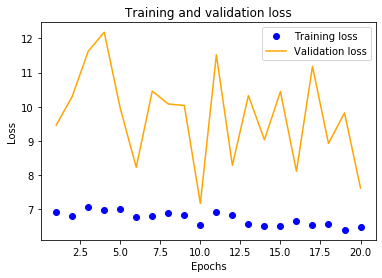

In [50]:
# let's see the training and validation loss by epoch
history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) #acc wasn't defined before
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
model.save("/content/drive/My Drive/Deep Learning/Week 2/Weather Prediction/Models/ConvNet_WindRregression_Model_qiz18023.h5")

#### 3) Model Validation

[INFO] predicting wind speed...


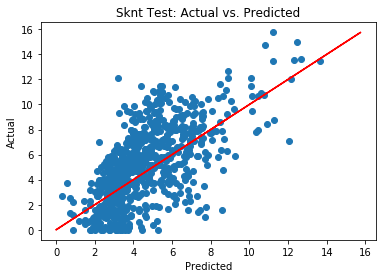

In [52]:
#7 make predictions for the testing data based on the model
print("[INFO] predicting wind speed...")
preds_test = model.predict(x_test)
plt.scatter(preds_test, y_test_3)
plt.title('Sknt Test: Actual vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.plot(y_test_3, y_test_3, color='red')
plt.savefig(result+'Sknt Test.png')

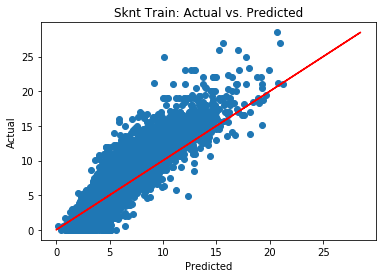

In [53]:
# actual vs. predicted on training
preds_train = model.predict(x_train)
plt.scatter(preds_train, y_train_3)
plt.title('Sknt Train: Actual vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.plot(y_train_3, y_train_3, color='red')
plt.savefig(result+'Sknt Training.png')

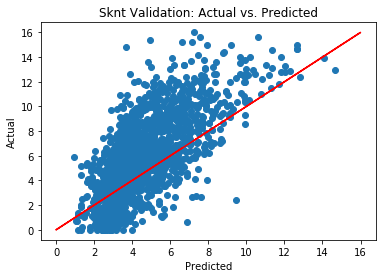

In [54]:
# actual vs. predicted on validation
preds_val = model.predict(x_val)
plt.scatter(preds_val, y_val_3)
plt.title('Sknt Validation: Actual vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.plot(y_val_3, y_val_3, color='red')
plt.savefig(result+'Sknt Validation.png')

### 2.3 Assessment of the Results

In [55]:
results = model.evaluate(x_test, y_test_3)
results

744/744 [==============================] - 0s 656us/sample - loss: 5.6621 - mean_absolute_error: 1.8935


[5.662147081026467, 1.8935214]

In [56]:
print(type(preds_test))
print(type(y_test_3))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [57]:
# Train dataset
# flatten the 1-D numpy array
myPreds = np.ndarray.flatten(preds_train)
myPreds = pd.DataFrame(myPreds)
myPreds.reset_index(drop=True)
myPreds.rename(columns={0: "preds_sknt"}, inplace=True)
myPreds['Type'] = 'train'
#actual predictions
myActual = pd.DataFrame(np.array(y_train_3))
myActual.reset_index(drop=True)
myActual.rename(columns={0: "actual_sknt"}, inplace=True)
allResults1 = pd.concat([myActual,myPreds], axis=1)
allResults1.head()

,actual_sknt,preds_sknt,Type
0,5.125000,3.938084,train
1,4.857143,4.322338,train
2,4.272727,5.486132,train
3,4.555556,3.700398,train
4,2.700000,4.237264,train


In [58]:
# Val dataset
# flatten the 1-D numpy array
myPreds = np.ndarray.flatten(preds_val)
myPreds = pd.DataFrame(myPreds)
myPreds.reset_index(drop=True)
myPreds.rename(columns={0: "preds_sknt"}, inplace=True)
myPreds['Type'] = 'val'
#actual predictions
myActual = pd.DataFrame(np.array(y_val_3))
myActual.reset_index(drop=True)
myActual.rename(columns={0: "actual_sknt"}, inplace=True)
allResults2 = pd.concat([myActual,myPreds], axis=1)
allResults2.head()

,actual_sknt,preds_sknt,Type
0,6.636364,4.028852,val
1,5.583333,3.536780,val
2,2.307692,5.411419,val
3,6.500000,4.288815,val
4,4.692308,4.347731,val


In [59]:
# Test dataset
# flatten the 1-D numpy array
myPreds = np.ndarray.flatten(preds_test)
myPreds = pd.DataFrame(myPreds)
myPreds.reset_index(drop=True)
myPreds.rename(columns={0: "preds_sknt"}, inplace=True)
myPreds['Type'] = 'test'
#actual predictions
myActual = pd.DataFrame(np.array(y_test_3))
myActual.reset_index(drop=True)
myActual.rename(columns={0: "actual_sknt"}, inplace=True)
allResults3 = pd.concat([myActual,myPreds], axis=1)
allResults3.head()

,actual_sknt,preds_sknt,Type
0,8.833333,4.491956,test
1,6.076923,4.659609,test
2,4.615385,3.865591,test
3,3.307692,3.441023,test
4,3.076923,3.595720,test


In [48]:
# combine all three datasets
allResults = pd.concat([allResults1,allResults2,allResults3], axis=0)
allResults.groupby("Type").count()

,actual_sknt,preds_sknt
Type,,
test,744,744
train,6511,6511
val,1464,1464


# **Part 2: ConvNet Binary Classification for Temprature**

### 2.1 Prepare the Data

In [60]:
# Create a binary target variable using tmpf, assign above average temperature to 1
above_avg = target_data[target_data['tmpf']>= target_data['tmpf'].mean()]
below_avg = target_data[target_data['tmpf']< target_data['tmpf'].mean()]
above_avg['tmpf'] = 1
below_avg['tmpf'] = 0
binary_target_data = pd.concat([above_avg,below_avg], axis=0)
binary_target_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,tmpf,drct,sknt
valid,,,
2016-09-01 00:00:00,1,222.500000,5.125000
2016-09-01 01:00:00,1,202.857143,4.857143
2016-09-01 02:00:00,1,218.181818,4.272727
2016-09-01 03:00:00,1,204.444444,4.555556
2016-09-01 04:00:00,1,145.000000,2.700000


In [0]:
#3 set train and test dataset
a = pd.Timestamp('2017/06/01 00:00:00')
b = pd.Timestamp('2017/08/01 00:00:00')
bi_sample = binary_target_data[binary_target_data.index < b]
bi_train = binary_target_data[binary_target_data.index < a]
bi_val = bi_sample[bi_sample.index >= a]
bi_test = binary_target_data[binary_target_data.index >= b]
# separate the data into train, validation and test
# tmpf model
y_train_4 = bi_train['tmpf']
y_val_4 = bi_val['tmpf']
y_test_4 = bi_test['tmpf']


In [62]:
#4:  check the shape
print("Image train dataset shape: ", x_train.shape, "Weather train dataset shape: ", bi_train.shape)
print("Image validation dataset shape: ", x_val.shape, "Weather validation dataset shape: ", bi_val.shape)
print("Image test dataset shape: ", x_test.shape, "Weather test dataset shape: ", bi_test.shape)

Image train dataset shape:  (6511, 125, 145, 3) Weather train dataset shape:  (6511, 3)
Image validation dataset shape:  (1464, 125, 145, 3) Weather validation dataset shape:  (1464, 3)
Image test dataset shape:  (744, 125, 145, 3) Weather test dataset shape:  (744, 3)


### 2.2 Binary Classification Model for Temperature

#### 1) Model Architecture

In [0]:
#5: build the CNN model
from keras.wrappers.scikit_learn import KerasClassifier
def create_bi_model():
  bi_model = tf.keras.Sequential()
  bi_model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', input_shape=(125,145,3))) 
  bi_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
  bi_model.add(tf.keras.layers.Dropout(0.3))
  bi_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
  bi_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
  bi_model.add(tf.keras.layers.Dropout(0.3))
  bi_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
  bi_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
  bi_model.add(tf.keras.layers.Dropout(0.3))
  bi_model.add(tf.keras.layers.Flatten())
  bi_model.add(tf.keras.layers.Dense(256, activation='relu'))
  bi_model.add(tf.keras.layers.Dense(128, activation='relu'))
  bi_model.add(tf.keras.layers.Dropout(0.5))
  bi_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  bi_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return bi_model
bi_model = KerasClassifier(build_fn=create_bi_model)

In [0]:
'''#opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(optimizer='rmsprop',loss="mse", metrics=['mae'])'''

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', 
                   # LOOK HOW QUICK IT STOPS IF YOU DON'T USE
                   # PATIENCE - SUBJECT TO NOISE!!!
                   # will vary based on every problem you tackle
                   # try a patience of 2, 5, 10, 50, 100...
                   # what do you notice?
                   patience=5, 
                   verbose=1)

#### 2) Model Fitting

In [67]:
#6: fit train data into the model
print("[INFO] training model...")
bi_history = bi_model.fit(x_train, y_train_4, validation_data=(x_val, y_val_4), epochs=500, batch_size=50,verbose=1,callbacks=[es])

[INFO] training model...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 6511 samples, validate on 1464 samples
Epoch 1/500
6511/6511 [==============================] - 16s 2ms/sample - loss: 4.6215 - acc: 0.8195 - val_loss: 0.4534 - val_acc: 0.8135
Epoch 2/500
6511/6511 [==============================] - 15s 2ms/sample - loss: 0.2407 - acc: 0.9062 - val_loss: 0.3351 - val_acc: 0.8634
Epoch 3/500
6511/6511 [==============================] - 15s 2ms/sample - loss: 0.2130 - acc: 0.9169 - val_loss: 0.6229 - val_acc: 0.7951
Epoch 4/500
6511/6511 [==============================] - 15s 2ms/sample - loss: 0.2017 - acc: 0.9212 - val_loss: 0.8399 - val_acc: 0.7616
Epoch 5/500
6511/6511 [==============================] - 15s 2ms/sample - loss: 0.1688 - acc: 0.9292 - val_loss: 1.8337 - val_acc: 0.6175
Epoch 6/500
6511/6511 [==============================] - 16s 2ms/sample - loss: 0.1593 - acc: 0.9343 - val_loss: 1.0782 - val_acc: 0.6947
Epoch

In [68]:
# let's try to extract from history.history
bi_x = np.array(bi_history.epoch)
bi_x = max(bi_x)
print("We should re-run for this many epochs: ", bi_x)

We should re-run for this many epochs:  6


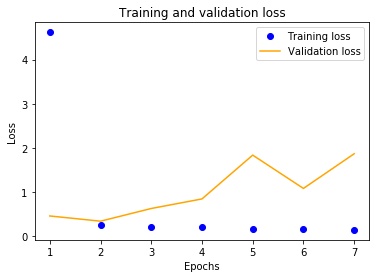

In [69]:
# let's see the training and validation loss by epoch
bi_history_dict = bi_history.history
loss_values = bi_history_dict['loss'] # you can change this
val_loss_values = bi_history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) #acc wasn't defined before
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
model.save("/content/drive/My Drive/Deep Learning/Week 2/Weather Prediction/Models/ConvNet_TemperatureClassification_Model_qiz18023.h5")

#### 3) Model Validation

In [0]:
# make predictions on the testing dataset
bi_preds_test = bi_model.predict(x_test)

In [72]:
from sklearn.metrics import confusion_matrix, classification_report
def get_confusion_matrix_values(y_true, y_pred):
  cm=confusion_matrix(y_true, y_pred)
  return(cm[0][0], cm[0][1], cm[1][0], cm[1][1])

# Confusion Matrix of the testing dataset 
print("[INFO] Testing Dataset Confusion Matrix")
pd.DataFrame(confusion_matrix(y_test_4, bi_preds_test))

[INFO] Testing Dataset Confusion Matrix


,0,1
0,0,4
1,0,740


In [73]:
from sklearn.metrics import accuracy_score

# Accuracy of the testing dataset
bi_test_score = accuracy_score(y_test_4, bi_preds_test)
print("Testing Dataset Accuracy Score = ",bi_test_score)

Testing Dataset Accuracy Score =  0.9946236559139785


In [74]:
# Confusion Matrix of the training dataset 
bi_preds_train = bi_model.predict(x_train)
print("[INFO] Training Dataset Confusion Matrix")
pd.DataFrame(confusion_matrix(y_train_4, bi_preds_train))

[INFO] Training Dataset Confusion Matrix


,0,1
0,4182,80
1,268,1981


In [75]:
# Accuracy of the training dataset
bi_train_score = accuracy_score(y_train_4, bi_preds_train)
print("Training Dataset Accuracy Score = ", bi_train_score)

Training Dataset Accuracy Score =  0.9465519889417908


In [76]:
# Confusion Matrix of the validation dataset 
bi_preds_val = bi_model.predict(x_val)
print("[INFO] Validation Dataset Confusion Matrix")
pd.DataFrame(confusion_matrix(y_val_4, bi_preds_val))

[INFO] Validation Dataset Confusion Matrix


,0,1
0,0,50
1,257,1157


In [77]:
# Accuracy of the validation dataset
bi_val_score = accuracy_score(y_val_4, bi_preds_val)
print("Validation Dataset Accuracy Score = ",bi_val_score)

Validation Dataset Accuracy Score =  0.7903005464480874


In [78]:
# Accuracy Table
data = {'Accuracy':[bi_train_score, bi_val_score, bi_test_score]} 
Accuracy_Table = pd.DataFrame(data, index=['Train', 'Validation', 'Test']) 
Accuracy_Table.to_csv('/content/drive/My Drive/Deep Learning/Week 2/Weather Prediction/Models/tmpf_accuracy_table.csv')
Accuracy_Table 

,Accuracy
Train,0.946552
Validation,0.790301
Test,0.994624


### 2.3 Assessment of the Results

In [79]:
# Train dataset
# flatten the 1-D numpy array
myClassify = np.ndarray.flatten(bi_preds_train)
myClassify = pd.DataFrame(myClassify)
myClassify.reset_index(drop=True)
myClassify.rename(columns={0: "classify_tmpf"}, inplace=True)
myClassify['Type'] = 'train'
#actual predictions
myBiActual = pd.DataFrame(np.array(y_train_4))
myBiActual.reset_index(drop=True)
myBiActual.rename(columns={0: "bi_actual_tmpf"}, inplace=True)
allResults4 = pd.concat([myBiActual,myClassify], axis=1)
allResults4.head()

,bi_actual_tmpf,classify_tmpf,Type
0,1,1,train
1,1,1,train
2,1,1,train
3,1,1,train
4,1,1,train


In [80]:
# Validation dataset
# flatten the 1-D numpy array
myClassify = np.ndarray.flatten(bi_preds_val)
myClassify = pd.DataFrame(myClassify)
myClassify.reset_index(drop=True)
myClassify.rename(columns={0: "classify_tmpf"}, inplace=True)
myClassify['Type'] = 'val'
#actual predictions
myBiActual = pd.DataFrame(np.array(y_val_4))
myBiActual.reset_index(drop=True)
myBiActual.rename(columns={0: "bi_actual_tmpf"}, inplace=True)
allResults5 = pd.concat([myBiActual,myClassify], axis=1)
allResults5.head()

,bi_actual_tmpf,classify_tmpf,Type
0,1,0,val
1,1,0,val
2,1,0,val
3,1,0,val
4,1,0,val


In [82]:
# Test dataset
# flatten the 1-D numpy array
myClassify = np.ndarray.flatten(bi_preds_test)
myClassify = pd.DataFrame(myClassify)
myClassify.reset_index(drop=True)
myClassify.rename(columns={0: "classify_tmpf"}, inplace=True)
myClassify['Type'] = 'test'
#actual predictions
myBiActual = pd.DataFrame(np.array(y_test_4))
myBiActual.reset_index(drop=True)
myBiActual.rename(columns={0: "bi_actual_tmpf"}, inplace=True)
allResults6 = pd.concat([myBiActual,myClassify], axis=1)
allResults6.head()

,bi_actual_tmpf,classify_tmpf,Type
0,1,1,test
1,1,1,test
2,1,1,test
3,1,1,test
4,1,1,test


In [83]:
# combine all three datasets
allClassifyResults = pd.concat([allResults4,allResults5,allResults6], axis=0)
allClassifyResults.groupby("Type").count()

,bi_actual_tmpf,classify_tmpf
Type,,
test,744,744
train,6511,6511
val,1464,1464


## -End-